## 07. PyTorch Experiment Tracking Exercise Template
Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

* Note: There may be more than one solution to each of the exercises. This notebook only shows one possible example.

* Resources
* These exercises/solutions are based on section [07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
* See a live [walkthrough of the solutions](https://youtu.be/cO_r2FYcAjU) (errors and all) on YouTube.
* See other [solutions on the course GitHub.](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions)

In [5]:
# Getting the setup
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [5]:
 # Make sure we have a GPU
 device = "cuda" if torch.cuda.is_available() else "cpu"
 device

'cuda'

In [1]:
# Get regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

#### Create a helper function to set seeds


In [7]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### 1. Get data
* As always, before we can run machine learning experiments, we'll need a dataset.

* We're going to continue trying to improve upon the results we've been getting on FoodVision Mini.

* In the previous section, 06. PyTorch Transfer Learning, we saw how powerful using a pretrained model and transfer learning could be when classifying images of pizza, steak and sushi.

* So how about we run some experiments and try to further improve our results?

* To do so, we'll use similar code to the previous section to download the pizza_steak_sushi.zip (if the data doesn't already exist) except this time its been functionised.

In [8]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [12]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [18]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs\2024-07-31\test_experiment_name\this_is_the_model_name\add_a_little_extra_if_you_want...


In [16]:
from going_modular.engine import train_step, test_step
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train() python script
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [11]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [12]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [9]:
from torchvision import transforms

# Create a transform to normalize data distrribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# create a pipeline
simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # this value can be anything you want
    transforms.ToTensor(), # get image values between 0 and 1
    normalize
])

#### Turn Dataset into DataLoaders

In [10]:
from going_modular import data_setup

In [11]:
BATCH_SIZE = 32
# Create a 10% percent training and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=1
)
# Create 1 20% percent traing and testing dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=1
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 2: Pick a larger model from torchvision.models to add to the list of experiments (for example, EffNetB3 or higher)
* How does it perform compared to our existing models?
* Hint: You'll need to set up an exerpiment similar to 07. [PyTorch Experiment Tracking section](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code) 7.6.
* lets try Efficient V2 small model
* Previously we had b2 which had 9million parameters now -> 21Million Parameters

Create Models

In [14]:
# create a new effnet v2 small model
from torchvision import models
effnetv2_s_weights = models.EfficientNet_V2_S_Weights.DEFAULT
effnetv2_s = models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)
#effnetv2_s

In [15]:
from torchinfo import summary

summary(effnetv2_s, input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         5,232
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                         

In [23]:
# Let us now functionize the model selection
import torchvision
from torch import nn

def create_model(model_name: str,
                 out_features: int=3,
                 device: str=device):
    assert model_name == "effnetb2" or model_name == "effnetv2_s", "Model name should be effnetb2 or effnetv2_s"
    if model_name == "effnetb2":
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
        model = torchvision.models.efficientnet_b2(weights=weights).to(device)
        dropout = 0.3
        in_features = 1408
    elif model_name == "effnetv2_s":
        weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
        dropout = 0.2
        in_features = 1280

    # Freeze the base layer of the models
    for param in model.parameters():
        param.requires_grad = False

    # Update the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features,out_features=out_features)
    ).to(device)

    # set the model name
    model.name = model_name
    print(f"[INFO] Creating {model_name} feature extractor model...")
    return model

In [36]:
effnetb2 = create_model(model_name="effnetb2",
                        out_features=len(class_names))

[INFO] Creating effnetb2 feature extractor model...


#### 7.6 Setup modeling experiments
going to use similar code for our modeling experiments, mainly want to substitue effnetb2 experiments with effnetv2_s in its place

In [40]:
# create expoch list
num_epochs = [5, 10]

# Create a model list
models = ["effnetb2", "effnetv2_s"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [41]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = create_model(model_name=model_name,
                                    out_features=len(class_names)) # Create a new model

            # if model_name == "effnetb2":
            #     model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            # elif model_name == "effnetv2_s":
            #     model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-25\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9769 | train_acc: 0.5664 | test_loss: 0.9518 | test_acc: 0.6506
Epoch: 2 | train_loss: 0.8197 | train_acc: 0.7500 | test_loss: 0.8587 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7843 | train_acc: 0.6562 | test_loss: 0.8006 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.6700 | train_acc: 0.7695 | test_loss: 0.6917 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5779 | train_acc: 0.9375 | test_loss: 0.6938 | test_acc: 0.8466
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-25\data_10_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0748 | train_acc: 0.5117 | test_loss: 0.9611 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9070 | train_acc: 0.7734 | test_loss: 0.8526 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7913 | train_acc: 0.8125 | test_loss: 0.7428 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7166 | train_acc: 0.8438 | test_loss: 0.6590 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6821 | train_acc: 0.7305 | test_loss: 0.5922 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-25\data_10_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0627 | train_acc: 0.3945 | test_loss: 0.9716 | test_acc: 0.6307
Epoch: 2 | train_loss: 0.9210 | train_acc: 0.5469 | test_loss: 0.8843 | test_acc: 0.7140
Epoch: 3 | train_loss: 0.8103 | train_acc: 0.6641 | test_loss: 0.7308 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7278 | train_acc: 0.7500 | test_loss: 0.7024 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.6134 | train_acc: 0.9258 | test_loss: 0.6872 | test_acc: 0.8674
Epoch: 6 | train_loss: 0.5564 | train_acc: 0.9102 | test_loss: 0.6660 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.6343 | train_acc: 0.7539 | test_loss: 0.6240 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5207 | train_acc: 0.9336 | test_loss: 0.5642 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.4950 | train_acc: 0.8125 | test_loss: 0.5422 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5095 | train_acc: 0.8008 | test_loss: 0.5203 | test_acc: 0.9081
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0336 | train_acc: 0.5742 | test_loss: 0.9641 | test_acc: 0.6222
Epoch: 2 | train_loss: 0.9134 | train_acc: 0.6133 | test_loss: 0.8442 | test_acc: 0.7140
Epoch: 3 | train_loss: 0.7768 | train_acc: 0.7227 | test_loss: 0.7572 | test_acc: 0.7945
Epoch: 4 | train_loss: 0.7186 | train_acc: 0.7578 | test_loss: 0.6514 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6578 | train_acc: 0.7539 | test_loss: 0.6402 | test_acc: 0.7841
Epoch: 6 | train_loss: 0.6349 | train_acc: 0.7617 | test_loss: 0.6232 | test_acc: 0.8144
Epoch: 7 | train_loss: 0.5608 | train_acc: 0.8164 | test_loss: 0.5497 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.5514 | train_acc: 0.7852 | test_loss: 0.5586 | test_acc: 0.8049
Epoch: 9 | train_loss: 0.5001 | train_acc: 0.9336 | test_loss: 0.5295 | test_acc: 0.8248
Epoch: 10 | train_loss: 0.5286 | train_acc: 0.7734 | test_loss: 0.5235 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_10_epochs.pth
----------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9789 | train_acc: 0.5583 | test_loss: 0.7780 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.7419 | train_acc: 0.7354 | test_loss: 0.6894 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.6114 | train_acc: 0.8292 | test_loss: 0.5558 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5637 | train_acc: 0.8750 | test_loss: 0.5324 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.5078 | train_acc: 0.8625 | test_loss: 0.5254 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-25\data_20_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9758 | train_acc: 0.5646 | test_loss: 0.7829 | test_acc: 0.8447
Epoch: 2 | train_loss: 0.7440 | train_acc: 0.7750 | test_loss: 0.6040 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.6549 | train_acc: 0.7688 | test_loss: 0.5274 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.5295 | train_acc: 0.8583 | test_loss: 0.4737 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5197 | train_acc: 0.8479 | test_loss: 0.4279 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-25\data_20_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0500 | train_acc: 0.4833 | test_loss: 0.8685 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.8057 | train_acc: 0.7542 | test_loss: 0.7280 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6681 | train_acc: 0.8313 | test_loss: 0.6332 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.6244 | train_acc: 0.7917 | test_loss: 0.5741 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4802 | train_acc: 0.9021 | test_loss: 0.5360 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.4557 | train_acc: 0.8667 | test_loss: 0.5209 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.4224 | train_acc: 0.9104 | test_loss: 0.4260 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3975 | train_acc: 0.8833 | test_loss: 0.4740 | test_acc: 0.8570
Epoch: 9 | train_loss: 0.3753 | train_acc: 0.8833 | test_loss: 0.4178 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.3042 | train_acc: 0.9313 | test_loss: 0.3952 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9624 | train_acc: 0.6042 | test_loss: 0.7817 | test_acc: 0.7642
Epoch: 2 | train_loss: 0.7040 | train_acc: 0.7979 | test_loss: 0.6269 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.6014 | train_acc: 0.8604 | test_loss: 0.5497 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.4973 | train_acc: 0.8688 | test_loss: 0.5028 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.5137 | train_acc: 0.8146 | test_loss: 0.4517 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4527 | train_acc: 0.8792 | test_loss: 0.4208 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.4171 | train_acc: 0.8854 | test_loss: 0.4036 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.4263 | train_acc: 0.8708 | test_loss: 0.4136 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.3483 | train_acc: 0.8979 | test_loss: 0.3786 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.3481 | train_acc: 0.8896 | test_loss: 0.3662 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_10_epochs.pth
----------------------------------

### 8. View the experiment in Tensorboard

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

### 9. Introduce Data augmentation to the list of experiments using the 20% data , does anything change?
* For example, you could have one training DataLoader that uses data augmentation (e.g. train_dataloader_20_percent_aug and train_dataloader_20_percent_no_aug) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note**: You may need to alter the create_dataloaders() function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

1. A 20% dataloader with augmentation
2. A 20% dataloader without augmentation

In [2]:
# Create our data augmentation transform
# let use trvialaugment()

from torchvision import transforms

# Create a transform to normalize data distrribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# create a pipeline for data augmentation
data_aug_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # this value can be anything you want
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(), # get image values between 0 and 1
    normalize
])

# create a non-data augmentation
no_data_aug_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

In [4]:
# Create the dataloaders, lets do it by updating the
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str,
    train_transform: transforms.Compose, ## New addition (want to do augmentatin only on the training data)
    test_transform: transforms.Compose, ## New Addition
    #transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform) # New
  test_data = datasets.ImageFolder(test_dir, transform=test_transform) # New

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [15]:

test_dir_20_percent = data_20_percent_path / "test"
# Creating train and test dataloaders
BATCH_SIZE = 32
# Create a 20% percent training and test dataloaders with augmentation
train_dataloader_20_percent_with_aug, test_dataloader_20_percent_with_aug, class_names = create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20_percent,
    train_transform=data_aug_transform,
    test_transform=no_data_aug_transform,
    batch_size=BATCH_SIZE,
    num_workers=1
)
# Create 1 20% percent traing and testing dataloaders without augmentation
train_dataloader_20_percent_without_aug, test_dataloader_20_percent_without_aug, class_names = create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20_percent,
    train_transform=data_aug_transform,
    test_transform=no_data_aug_transform,
    batch_size=BATCH_SIZE,
    num_workers=1
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
# print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent_with_aug)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data without aug: {len(train_dataloader_20_percent_without_aug)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader_20_percent_with_aug)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in 20 percent training data without aug: 15
Number of batches of size 32 in testing data: 5 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [20]:
import matplotlib.pyplot as plt
# Helper function to view images in a DataLoader (works with data augmentation transforms or not) 
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, n, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

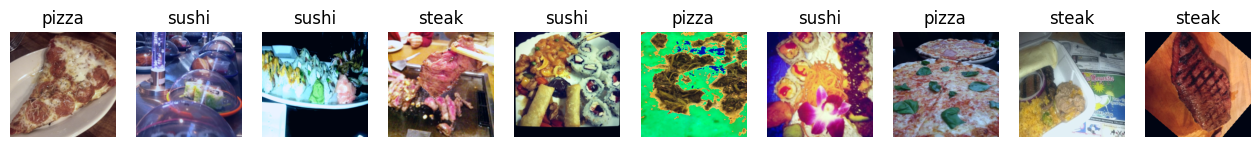

In [22]:
view_dataloader_images(train_dataloader_20_percent_with_aug, n=10)

Run data aug vs no data aug

In [27]:
num_epochs = [10,15]

# create dataloaders dicitonary for various dataloaders
# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
                     "data_20_percent_without_aug": train_dataloader_20_percent_without_aug}

# create model
models = ["effnetv2_s"]

In [30]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = create_model(model_name=model_name,
                                    out_features=len(class_names)) # Create a new model

            # if model_name == "effnetb2":
            #     model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            # elif model_name == "effnetv2_s":
            #     model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader_20_percent_with_aug, # New test_dataloaders
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 10
[INFO] Creating effnetv2_s feature extractor model...
[INFO] Created SummaryWriter, saving to: runs\2024-07-26\data_20_percent_with_aug\effnetv2_s\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9538 | train_acc: 0.6167 | test_loss: 0.7529 | test_acc: 0.8341
Epoch: 2 | train_loss: 0.7547 | train_acc: 0.8000 | test_loss: 0.5853 | test_acc: 0.8699
Epoch: 3 | train_loss: 0.6698 | train_acc: 0.7896 | test_loss: 0.4916 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.5967 | train_acc: 0.8104 | test_loss: 0.4662 | test_acc: 0.9040
Epoch: 5 | train_loss: 0.4905 | train_acc: 0.8729 | test_loss: 0.4320 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4907 | train_acc: 0.8479 | test_loss: 0.3877 | test_acc: 0.9102
Epoch: 7 | train_loss: 0.4973 | train_acc: 0.8063 | test_loss: 0.3744 | test_acc: 0.9068
Epoch: 8 | train_loss: 0.4765 | train_acc: 0.8167 | test_loss: 0.3806 | test_acc: 0.8915
Epoch: 9 | train_loss: 0.4881 | train_acc: 0.8292 | test_loss: 0.3479 | test_acc: 0.8886
Epoch: 10 | train_loss: 0.4354 | train_acc: 0.8417 | test_loss: 0.3178 | test_acc: 0.9222
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_with_aug_10_epochs.pth
-------------------------

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9969 | train_acc: 0.5208 | test_loss: 0.7336 | test_acc: 0.8517
Epoch: 2 | train_loss: 0.7584 | train_acc: 0.8021 | test_loss: 0.5900 | test_acc: 0.8642
Epoch: 3 | train_loss: 0.6200 | train_acc: 0.8583 | test_loss: 0.4963 | test_acc: 0.8642
Epoch: 4 | train_loss: 0.6049 | train_acc: 0.8229 | test_loss: 0.4824 | test_acc: 0.8432
Epoch: 5 | train_loss: 0.4899 | train_acc: 0.8562 | test_loss: 0.4249 | test_acc: 0.8943
Epoch: 6 | train_loss: 0.4741 | train_acc: 0.8583 | test_loss: 0.3824 | test_acc: 0.8761
Epoch: 7 | train_loss: 0.4564 | train_acc: 0.8667 | test_loss: 0.3597 | test_acc: 0.8761
Epoch: 8 | train_loss: 0.4903 | train_acc: 0.8125 | test_loss: 0.3431 | test_acc: 0.8886
Epoch: 9 | train_loss: 0.4109 | train_acc: 0.8938 | test_loss: 0.3298 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4236 | train_acc: 0.8542 | test_loss: 0.3182 | test_acc: 0.9040
Epoch: 11 | train_loss: 0.3764 | train_acc: 0.8812 | test_loss: 0.3076 | test_acc: 0.9102
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.5583 | test_loss: 0.7212 | test_acc: 0.9011
Epoch: 2 | train_loss: 0.7421 | train_acc: 0.7917 | test_loss: 0.5966 | test_acc: 0.9136
Epoch: 3 | train_loss: 0.6767 | train_acc: 0.7667 | test_loss: 0.5015 | test_acc: 0.8653
Epoch: 4 | train_loss: 0.5437 | train_acc: 0.8688 | test_loss: 0.4589 | test_acc: 0.8892
Epoch: 5 | train_loss: 0.5219 | train_acc: 0.8521 | test_loss: 0.4006 | test_acc: 0.9074
Epoch: 6 | train_loss: 0.5261 | train_acc: 0.8354 | test_loss: 0.3937 | test_acc: 0.9256
Epoch: 7 | train_loss: 0.4689 | train_acc: 0.8208 | test_loss: 0.3578 | test_acc: 0.9227
Epoch: 8 | train_loss: 0.5014 | train_acc: 0.8042 | test_loss: 0.3522 | test_acc: 0.8983
Epoch: 9 | train_loss: 0.4028 | train_acc: 0.9042 | test_loss: 0.3549 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.4236 | train_acc: 0.8812 | test_loss: 0.3190 | test_acc: 0.9284
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_without_aug_10_epochs.pth
----------------------

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0089 | train_acc: 0.5500 | test_loss: 0.7461 | test_acc: 0.8313
Epoch: 2 | train_loss: 0.7619 | train_acc: 0.7937 | test_loss: 0.5903 | test_acc: 0.9102
Epoch: 3 | train_loss: 0.6408 | train_acc: 0.8562 | test_loss: 0.5059 | test_acc: 0.8830
Epoch: 4 | train_loss: 0.5444 | train_acc: 0.8854 | test_loss: 0.4451 | test_acc: 0.8795
Epoch: 5 | train_loss: 0.5246 | train_acc: 0.8417 | test_loss: 0.3846 | test_acc: 0.9347
Epoch: 6 | train_loss: 0.4690 | train_acc: 0.8688 | test_loss: 0.3892 | test_acc: 0.9102
Epoch: 7 | train_loss: 0.4853 | train_acc: 0.8208 | test_loss: 0.3655 | test_acc: 0.9102
Epoch: 8 | train_loss: 0.4812 | train_acc: 0.8125 | test_loss: 0.3484 | test_acc: 0.9011
Epoch: 9 | train_loss: 0.4875 | train_acc: 0.8542 | test_loss: 0.3303 | test_acc: 0.9102
Epoch: 10 | train_loss: 0.4599 | train_acc: 0.8187 | test_loss: 0.3443 | test_acc: 0.9102
Epoch: 11 | train_loss: 0.4111 | train_acc: 0.8750 | test_loss: 0.3245 | test_acc: 0.9318
Epoch: 12 | train_l

Look's like the Effnetv2_s without data augmentation performed the best for test loss and test accuracy

### Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire Food101 dataset from torchvision.models
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from torchvision.models, you'll have to create PyTorch DataLoaders to use it in training.
* **Note**: Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.
* So lets train out effnetv2_s feature ectractor on all of our Food101 data.
* We will do for 5 epochs and 

In [3]:
import torch

In [31]:
# get the Food101 Dataset
import torchvision
from torchvision import transforms

# Create a transform to normalize data distrribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])
# create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

# Download and transform
train_data = torchvision.datasets.Food101(root="data",
                                       split="train",
                                       transform=simple_transform,
                                       download=True)
test_data = torchvision.datasets.Food101(root="data",
                                         split="test",
                                         transform=simple_transform,
                                         download=True)

In [21]:
import os

In [32]:
# Create Dataloaders
BATCH_SIZE = 512

train_dataloaders_big = torch.utils.data.DataLoader(train_data,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    num_workers=1,#os.cpu_count(), # for my cpu,
                                                    pin_memory=True) # Avoid copies of te data in and out of memory for speed ups
test_dataloader_big = torch.utils.data.DataLoader(test_data,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  num_workers=1,#os.cpu_count(),
                                                  pin_memory=True)

In [8]:
from torch import nn

In [33]:
# Create an effnetv2 model
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
foodvision_big = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)

# Freeze the base layers
for param in foodvision_big.parameters():
    param.requires_grad = False

# Chaneg the classifier head to suit 101 different classes
foodvision_big.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=101) # Output classes for FOOD101
    
)

In [34]:
from torchinfo import summary
summary(model=foodvision_big,
        input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 101]                  --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         (48)
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         (5,232)
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         (5,232)
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                 

In [35]:
foodvision_big_results = train(model=foodvision_big,
                               train_dataloader=train_dataloaders_big,
                               test_dataloader=test_dataloader_big,
                               optimizer=torch.optim.Adam(params=foodvision_big.parameters(),
                                                          lr=0.01),
                                loss_fn=torch.nn.CrossEntropyLoss(),
                                epochs=5,
                                device=device,
                                writer=create_writer(experiment_name="foodvision_101_all_data",
                                                     model_name="foodvision_big",
                                                     extra=f"Epochs_{5}"))

[INFO] Created SummaryWriter, saving to: runs\2024-07-31\foodvision_101_all_data\foodvision_big\Epochs_5...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7556 | train_acc: 0.3558 | test_loss: 2.0661 | test_acc: 0.4861
Epoch: 2 | train_loss: 2.4425 | train_acc: 0.4212 | test_loss: 2.0283 | test_acc: 0.4994
Epoch: 3 | train_loss: 2.4208 | train_acc: 0.4288 | test_loss: 2.0239 | test_acc: 0.4996
Epoch: 4 | train_loss: 2.4029 | train_acc: 0.4343 | test_loss: 2.0496 | test_acc: 0.4947
Epoch: 5 | train_loss: 2.3957 | train_acc: 0.4366 | test_loss: 2.0362 | test_acc: 0.4965


In [36]:
import matplotlib.pyplot as plt
# Helper function to view images in a DataLoader (works with data augmentation transforms or not) 
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, n, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)